In [1]:
import os
from dataclasses import dataclass


@dataclass
class TrainingConfig:
    image_size = 256
    image_channels = 3
    train_batch_size = 18
    eval_batch_size = 12
    num_epochs = 2
    start_epoch = 0
    learning_rate = 2e-4
    diffusion_timesteps = 1000
    save_image_epochs = 2
    save_model_epochs = 2
    dataset = os.path.expanduser('/home/u1117813/hw3/img_align_celeba/all_images')  # path to the training dataset (modify it according to your setting)
    output_dir = '/home/u1117813/hw3/output_models'
    device = "cuda"
    seed = 0  # random seed
    resume = None

training_config = TrainingConfig()

# Change the path to import the training data.

In [2]:
import torch
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import os
from PIL import Image

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU is not available")
data_path = os.path.expanduser('/home/u1117813/hw3/img_align_celeba/all_images')  # Dataset base path
img_files = os.listdir(data_path)  # List all files in the directory
img_path = [os.path.join(data_path, i) for i in img_files[:20000]]
class TrainDataset(Dataset):
    def __init__(self, transform=None):
        self.images_path = img_path
        self.transform = transform
    def __getitem__(self, index):
        single_img_path = self.images_path[index]
        image = Image.open(single_img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)
        return image
    def __len__(self):
        return len(self.images_path)

def get_loader(config):
    preprocess = transforms.Compose(
        [
            transforms.Resize((config.image_size, config.image_size)),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5]),
        ]
    )
    dataset = TrainDataset(transform=preprocess)
    loader = DataLoader(dataset, batch_size=config.train_batch_size, shuffle=True)
    return loader

GPU is available


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class TransformerPositionalEmbedding(nn.Module):
    """
    From paper "Attention Is All You Need", section 3.5
    """
    def __init__(self, dimension, max_timesteps=1000):
        super(TransformerPositionalEmbedding, self).__init__()
        assert dimension % 2 == 0, "Embedding dimension must be even"
        self.dimension = dimension
        self.pe_matrix = torch.zeros(max_timesteps, dimension)
        # Gather all the even dimensions across the embedding vector
        even_indices = torch.arange(0, self.dimension, 2)
        # Calculate the term using log transforms for faster calculations
        log_term = torch.log(torch.tensor(10000.0)) / self.dimension
        div_term = torch.exp(even_indices * -log_term)

        # Precompute positional encoding matrix based on odd/even timesteps
        timesteps = torch.arange(max_timesteps).unsqueeze(1)
        self.pe_matrix[:, 0::2] = torch.sin(timesteps * div_term)
        self.pe_matrix[:, 1::2] = torch.cos(timesteps * div_term)

    def forward(self, timestep):
        # [bs, d_model]
        # print('timestep',timestep.device,'self.pe_matrix.device',self.pe_matrix.device)
        self.pe_matrix = self.pe_matrix.to(timestep.device)


        return self.pe_matrix[timestep].to(timestep.device)


class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, groups=8):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.norm = nn.GroupNorm(groups, out_channels)
        self.act = nn.SiLU()

    def forward(self, x):
        x = self.conv(x)
        x = self.norm(x)
        x = self.act(x)
        return x


class DownsampleBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride, padding):
        super(DownsampleBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, 3, stride=stride, padding=padding)

    def forward(self, input_tensor):
        x = self.conv(input_tensor)
        return x


class UpsampleBlock(nn.Module):
    def __init__(self, in_channels, out_channels, scale_factor=2.0):
        super(UpsampleBlock, self).__init__()

        self.scale = scale_factor
        self.conv = nn.Conv2d(in_channels, out_channels, 3, padding=1)

    def forward(self, input_tensor):
        # align_corners=True for potential convertibility to ONNX
        x = F.interpolate(input_tensor, scale_factor=self.scale, mode="bilinear", align_corners=True)
        x = self.conv(x)
        return x


class ConvDownBlock(nn.Module):
    def __init__(self, in_channels, out_channels, num_layers, time_emb_channels, num_groups, downsample=True):
        super(ConvDownBlock, self).__init__()
        resnet_blocks = []
        for i in range(num_layers):
            in_channels = in_channels if i == 0 else out_channels
            resnet_block = ResNetBlock(in_channels=in_channels,
                                       out_channels=out_channels,
                                       time_emb_channels=time_emb_channels,
                                       num_groups=num_groups)
            resnet_blocks.append(resnet_block)

        self.resnet_blocks = nn.ModuleList(resnet_blocks)

        self.downsample = DownsampleBlock(in_channels=out_channels, out_channels=out_channels, stride=2, padding=1) \
            if downsample \
            else None

    def forward(self, input_tensor, time_embedding):
        x = input_tensor
        for resnet_block in self.resnet_blocks:
            x = resnet_block(x, time_embedding)
        if self.downsample:
            x = self.downsample(x)
        return x


class ConvUpBlock(nn.Module):
    def __init__(self, in_channels, out_channels, num_layers, time_emb_channels, num_groups, upsample=True):
        super(ConvUpBlock, self).__init__()
        resnet_blocks = []
        for i in range(num_layers):
            in_channels = in_channels if i == 0 else out_channels
            resnet_block = ResNetBlock(in_channels=in_channels,
                                       out_channels=out_channels,
                                       time_emb_channels=time_emb_channels,
                                       num_groups=num_groups)
            resnet_blocks.append(resnet_block)

        self.resnet_blocks = nn.ModuleList(resnet_blocks)

        self.upsample = UpsampleBlock(in_channels=out_channels, out_channels=out_channels) \
            if upsample \
            else None

    def forward(self, input_tensor, time_embedding):
        x = input_tensor
        for resnet_block in self.resnet_blocks:
            x = resnet_block(x, time_embedding)
        if self.upsample:
            x = self.upsample(x)
        return x


class SelfAttentionBlock(nn.Module):
    """
    Self-attention blocks are applied at the 16x16 resolution in the original DDPM paper.
    Implementation is based on "Attention Is All You Need" paper, Vaswani et al., 2015
    (https://arxiv.org/pdf/1706.03762.pdf)
    """
    def __init__(self, num_heads, in_channels, num_groups=32, embedding_dim=256):
        super(SelfAttentionBlock, self).__init__()
        # For each of heads use d_k = d_v = d_model / num_heads
        self.num_heads = num_heads
        self.d_model = embedding_dim
        self.d_keys = embedding_dim // num_heads
        self.d_values = embedding_dim // num_heads

        self.query_projection = nn.Linear(in_channels, embedding_dim)
        self.key_projection = nn.Linear(in_channels, embedding_dim)
        self.value_projection = nn.Linear(in_channels, embedding_dim)

        self.final_projection = nn.Linear(embedding_dim, embedding_dim)
        self.norm = nn.GroupNorm(num_channels=embedding_dim, num_groups=num_groups)

    def split_features_for_heads(self, tensor):
        # We receive Q, K and V at shape [batch, h*w, embedding_dim].
        # This method splits embedding_dim into 'num_heads' features so that
        # each channel becomes of size embedding_dim / num_heads.
        # Output shape becomes [batch, num_heads, h*w, embedding_dim/num_heads],
        # where 'embedding_dim/num_heads' is equal to d_k = d_k = d_v = sizes for
        # K, Q and V respectively, according to paper.
        batch, hw, emb_dim = tensor.shape
        channels_per_head = emb_dim // self.num_heads
        heads_splitted_tensor = torch.split(tensor, split_size_or_sections=channels_per_head, dim=-1)
        heads_splitted_tensor = torch.stack(heads_splitted_tensor, 1)
        return heads_splitted_tensor

    def forward(self, input_tensor):
        x = input_tensor
        batch, features, h, w = x.shape
        # Do reshape and transpose input tensor since we want to process depth feature maps, not spatial maps
        x = x.view(batch, features, h * w).transpose(1, 2)

        # Get linear projections of K, Q and V according to Fig. 2 in the original Transformer paper
        queries = self.query_projection(x)  # [b, in_channels, embedding_dim]
        keys = self.key_projection(x)       # [b, in_channels, embedding_dim]
        values = self.value_projection(x)   # [b, in_channels, embedding_dim]

        # Split Q, K, V between attention heads to process them simultaneously
        queries = self.split_features_for_heads(queries)
        keys = self.split_features_for_heads(keys)
        values = self.split_features_for_heads(values)

        # Perform Scaled Dot-Product Attention (eq. 1 in the Transformer paper).
        # Each SDPA block yields tensor of size d_v = embedding_dim/num_heads.
        scale = self.d_keys ** -0.5
        attention_scores = torch.softmax(torch.matmul(queries, keys.transpose(-1, -2)) * scale, dim=-1)
        attention_scores = torch.matmul(attention_scores, values)

        # Permute computed attention scores such that
        # [batch, num_heads, h*w, embedding_dim] --> [batch, h*w, num_heads, d_v]
        attention_scores = attention_scores.permute(0, 2, 1, 3).contiguous()

        # Concatenate scores per head into one tensor so that
        # [batch, h*w, num_heads, d_v] --> [batch, h*w, num_heads*d_v]
        concatenated_heads_attention_scores = attention_scores.view(batch, h * w, self.d_model)

        # Perform linear projection and reshape tensor such that
        # [batch, h*w, d_model] --> [batch, d_model, h*w] -> [batch, d_model, h, w]
        linear_projection = self.final_projection(concatenated_heads_attention_scores)
        linear_projection = linear_projection.transpose(-1, -2).reshape(batch, self.d_model, h, w)

        # Residual connection + norm
        x = self.norm(linear_projection + input_tensor)
        return x


class AttentionDownBlock(nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 num_layers,
                 time_emb_channels,
                 num_groups,
                 num_att_heads,
                 downsample=True):
        """
        AttentionDownBlock consists of ResNet blocks with Self-Attention blocks in-between
        :param in_channels:
        :param out_channels:
        :param num_layers:
        :param time_emb_channels:
        :param num_groups:
        :param num_att_heads:
        :param downsample:
        """
        super(AttentionDownBlock, self).__init__()

        resnet_blocks = []
        attention_blocks = []
        for i in range(num_layers):
            in_channels = in_channels if i == 0 else out_channels
            resnet_block = ResNetBlock(in_channels=in_channels,
                                       out_channels=out_channels,
                                       time_emb_channels=time_emb_channels,
                                       num_groups=num_groups)
            attention_block = SelfAttentionBlock(in_channels=out_channels,
                                                 embedding_dim=out_channels,
                                                 num_heads=num_att_heads,
                                                 num_groups=num_groups)

            resnet_blocks.append(resnet_block)
            attention_blocks.append(attention_block)

        self.resnet_blocks = nn.ModuleList(resnet_blocks)
        self.attention_blocks = nn.ModuleList(attention_blocks)

        self.downsample = DownsampleBlock(in_channels=out_channels, out_channels=out_channels, stride=2, padding=1) \
            if downsample \
            else None

    def forward(self, input_tensor, time_embedding):
        x = input_tensor
        for resnet_block, attention_block in zip(self.resnet_blocks, self.attention_blocks):
            x = resnet_block(x, time_embedding)
            x = attention_block(x)
        if self.downsample:
            x = self.downsample(x)
        return x


class AttentionUpBlock(nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 num_layers,
                 time_emb_channels,
                 num_groups,
                 num_att_heads,
                 upsample=True):
        """
        :param in_channels:
        :param out_channels:
        :param num_layers:
        :param time_emb_channels:
        :param num_groups:
        :param num_att_heads:
        :param upsample:
        """
        super(AttentionUpBlock, self).__init__()

        resnet_blocks = []
        attention_blocks = []
        for i in range(num_layers):
            in_channels = in_channels if i == 0 else out_channels
            resnet_block = ResNetBlock(in_channels=in_channels,
                                       out_channels=out_channels,
                                       time_emb_channels=time_emb_channels,
                                       num_groups=num_groups)
            attention_block = SelfAttentionBlock(in_channels=out_channels,
                                                 embedding_dim=out_channels,
                                                 num_heads=num_att_heads,
                                                 num_groups=num_groups)

            resnet_blocks.append(resnet_block)
            attention_blocks.append(attention_block)

        self.resnet_blocks = nn.ModuleList(resnet_blocks)
        self.attention_blocks = nn.ModuleList(attention_blocks)

        self.upsample = UpsampleBlock(in_channels=out_channels, out_channels=out_channels) \
            if upsample \
            else None

    def forward(self, input_tensor, time_embedding):
        x = input_tensor
        for resnet_block, attention_block in zip(self.resnet_blocks, self.attention_blocks):
            x = resnet_block(x, time_embedding)
            x = attention_block(x)
        if self.upsample:
            x = self.upsample(x)
        return x


class ResNetBlock(nn.Module):
    """
    In the original DDPM paper Wide ResNet was used
    (https://arxiv.org/pdf/1605.07146.pdf).
    """
    def __init__(self, in_channels, out_channels, *, time_emb_channels=None, num_groups=8):
        super(ResNetBlock, self).__init__()
        self.time_embedding_projectile = (
            nn.Sequential(nn.SiLU(), nn.Linear(time_emb_channels, out_channels))
            if time_emb_channels
            else None
        )

        self.block1 = ConvBlock(in_channels, out_channels, groups=num_groups)
        self.block2 = ConvBlock(out_channels, out_channels, groups=num_groups)
        self.residual_conv = nn.Conv2d(in_channels, out_channels, 1) if in_channels != out_channels else nn.Identity()

    def forward(self, x, time_embedding=None):
        input_tensor = x
        h = self.block1(x)
        # According to authors implementations, they inject timestep embedding into the network
        # using MLP after the first conv block in all the ResNet blocks
        # (https://github.com/hojonathanho/diffusion/blob/1e0dceb3b3495bbe19116a5e1b3596cd0706c543/diffusion_tf/models/unet.py#L49)

        time_emb = self.time_embedding_projectile(time_embedding)
        time_emb = time_emb[:, :, None, None]
        x = time_emb + h

        x = self.block2(x)
        return x + self.residual_conv(input_tensor)

In [4]:
import torch
import torch.nn as nn




class UNet(nn.Module):
    """
    Model architecture as described in the DDPM paper, Appendix, section B
    """

    def __init__(self, image_size=256, input_channels=3):
        super().__init__()


        self.initial_conv = nn.Conv2d(in_channels=input_channels, out_channels=128, kernel_size=3, stride=1, padding='same')
        self.positional_encoding = nn.Sequential(
            TransformerPositionalEmbedding(dimension=128),
            nn.Linear(128, 128 * 4),
            nn.GELU(),
            nn.Linear(128 * 4, 128 * 4)
        )

        self.downsample_blocks = nn.ModuleList([
            ConvDownBlock(in_channels=128, out_channels=128, num_layers=2, num_groups=32, time_emb_channels=128 * 4),
            ConvDownBlock(in_channels=128, out_channels=128, num_layers=2, num_groups=32, time_emb_channels=128 * 4),
            ConvDownBlock(in_channels=128, out_channels=256, num_layers=2, num_groups=32, time_emb_channels=128 * 4),
            AttentionDownBlock(in_channels=256, out_channels=256, num_layers=2, num_att_heads=4, num_groups=32, time_emb_channels=128 * 4),
            ConvDownBlock(in_channels=256, out_channels=512, num_layers=2, num_groups=32, time_emb_channels=128 * 4)
        ])

        self.bottleneck = AttentionDownBlock(in_channels=512, out_channels=512, num_layers=2, num_att_heads=4, num_groups=32, time_emb_channels=128*4, downsample=False)                                                                                                  # 16x16x256 -> 16x16x256

        self.upsample_blocks = nn.ModuleList([
            ConvUpBlock(in_channels=512 + 512, out_channels=512, num_layers=2, num_groups=32, time_emb_channels=128 * 4),
            AttentionUpBlock(in_channels=512 + 256, out_channels=256, num_layers=2, num_att_heads=4, num_groups=32, time_emb_channels=128 * 4),
            ConvUpBlock(in_channels=256 + 256, out_channels=256, num_layers=2, num_groups=32, time_emb_channels=128 * 4),
            ConvUpBlock(in_channels=256 + 128, out_channels=128, num_layers=2, num_groups=32, time_emb_channels=128 * 4),
            ConvUpBlock(in_channels=128 + 128, out_channels=128, num_layers=2, num_groups=32, time_emb_channels=128 * 4)
        ])

        self.output_conv = nn.Sequential(
            nn.GroupNorm(num_channels=256, num_groups=32),
            nn.SiLU(),
            nn.Conv2d(256, 3, 3, padding=1)
        )

    def forward(self, input_tensor, time):
        time_encoded = self.positional_encoding(time)

        initial_x = self.initial_conv(input_tensor)

        states_for_skip_connections = [initial_x]

        x = initial_x
        for i, block in enumerate(self.downsample_blocks):
            x = block(x, time_encoded)
            states_for_skip_connections.append(x)
        states_for_skip_connections = list(reversed(states_for_skip_connections))

        x = self.bottleneck(x, time_encoded)

        for i, (block, skip) in enumerate(zip(self.upsample_blocks, states_for_skip_connections)):
            x = torch.cat([x, skip], dim=1)
            x = block(x, time_encoded)

        # Concat initial_conv with tensor
        x = torch.cat([x, states_for_skip_connections[-1]], dim=1)
        # Get initial shape [3, 256, 256] with convolutions
        out = self.output_conv(x)

        return out

# DDPM's foward & backward processes

In [5]:
import torch
import numpy as np

from tqdm import tqdm


class DDPMPipeline:
    def __init__(self, beta_start=1e-4, beta_end=1e-2, num_timesteps=1000):
        # Betas settings are in section 4 of https://arxiv.org/pdf/2006.11239.pdf
        # Implemented linear schedule for now, cosine works better tho.
        self.betas = torch.linspace(beta_start, beta_end, num_timesteps)
        self.alphas = 1 - self.betas

        # alpha-hat in the paper, precompute them
        self.alphas_hat = torch.cumprod(self.alphas, dim=0)

        self.num_timesteps = num_timesteps

    def forward_diffusion(self, images, timesteps) -> tuple[torch.Tensor, torch.Tensor]:
        """
        https://arxiv.org/pdf/2006.11239.pdf, equation (14), the term inside epsilon_theta
        :return:

        :param images: Input images
        :param timesteps: current timestamp
        :return: diffused image
        """

        gaussian_noise = torch.randn(images.shape).to(images.device)
        self.alphas_hat = self.alphas_hat.to(timesteps.device)
        # print('self.alphas_hat',self.alphas_hat.device,'timesteps',timesteps.device)
        alpha_hat = self.alphas_hat[timesteps].to(images.device)
        alpha_hat = broadcast(alpha_hat, images)

        return torch.sqrt(alpha_hat) * images + torch.sqrt(1 - alpha_hat) * gaussian_noise, gaussian_noise

    def reverse_diffusion(self, model, noisy_images, timesteps):

        predicted_noise = model(noisy_images, timesteps)
        return predicted_noise

    @torch.no_grad()
    def sampling(self, model, initial_noise, device, save_all_steps=False):
        """
        Algorithm 2 from the paper https://arxiv.org/pdf/2006.11239.pdf

        """
        image = initial_noise
        images = []
        for timestep in tqdm(range(self.num_timesteps - 1, -1, -1)):
            # Broadcast timestep for batch_size
            ts = timestep * torch.ones(image.shape[0], dtype=torch.long, device=device)
            predicted_noise = model(image, ts)
            beta_t = self.betas[timestep].to(device)
            alpha_t = self.alphas[timestep].to(device)
            alpha_hat = self.alphas_hat[timestep].to(device)

            # Algorithm 2, step 4: calculate x_{t-1} with alphas and variance.
            # Since paper says we can use fixed variance (section 3.2, in the beginning),
            # we will calculate the one which assumes we have x0 deterministically set to one point.
            alpha_hat_prev = self.alphas_hat[timestep - 1].to(device)
            beta_t_hat = (1 - alpha_hat_prev) / (1 - alpha_hat) * beta_t
            variance = torch.sqrt(beta_t_hat) * torch.randn(image.shape).to(device) if timestep > 0 else 0

            image = torch.pow(alpha_t, -0.5) * (image -
                                  beta_t / torch.sqrt((1 - alpha_hat_prev)) *
                                  predicted_noise) + variance
            if save_all_steps:
                images.append(image.cpu())
        return images if save_all_steps else image

In [6]:
import torch
import matplotlib.pyplot as plt
import matplotlib.animation as animation

from PIL import Image
from pathlib import Path

def broadcast(values, broadcast_to):
    values = values.flatten()

    while len(values.shape) < len(broadcast_to.shape):
        values = values.unsqueeze(-1)

    return values


def postprocess(images):
    images = (images / 2 + 0.5).clamp(0, 1)
    images = images.cpu().permute(0, 2, 3, 1).numpy()
    images = (images * 255).round().astype("uint8")
    return images


def create_images_grid(images, rows, cols):
    images = [Image.fromarray(image) for image in images]
    w, h = images[0].size
    grid = Image.new('RGB', size=(cols * w, rows * h))
    for i, image in enumerate(images):
        grid.paste(image, box=(i % cols * w, i // cols * h))
    return grid


def create_sampling_animation(model, pipeline, config, interval=5, every_nth_image=1, rows=2, cols=3):
    # Sample some images from random noise (this is the backward diffusion process).
    # The default pipeline output type is `List[PIL.Image]`
    noisy_sample = torch.randn(
        config.eval_batch_size,
        config.image_channels,
        config.image_size,
        config.image_size).to(config.device)

    # images is a list of num_timesteps images batches, e.g. List[Tensor(NCHW)]
    images = pipeline.sampling(model, noisy_sample, device=config.device, save_all_steps=True)

    fig = plt.figure()
    ims = []
    for i in range(0, pipeline.num_timesteps, every_nth_image):
        imgs = postprocess(images[i])
        image_grid = create_images_grid(imgs, rows=rows, cols=cols)
        im = plt.imshow(image_grid, animated=True)
        ims.append([im])

    plt.axis('off')
    animate = animation.ArtistAnimation(fig, ims, interval=interval, blit=True, repeat_delay=5000)
    path_to_save_animation = Path(config.output_dir, "samples", "diffusion.gif")
    animate.save(str(path_to_save_animation))

# **Training**

In [7]:
import torch

import torch.nn.functional as F

from tqdm import tqdm
from pathlib import Path



def evaluate(config, epoch, pipeline, model):
    # Perform reverse diffusion process with noisy images.
    noisy_sample = torch.randn(
        config.eval_batch_size,
        config.image_channels,
        config.image_size,
        config.image_size).to(device)

    # Reverse diffusion for T timesteps
    images = pipeline.sampling(model, noisy_sample, device=torch.device("cuda"))

    # Postprocess and save sampled images
    images = postprocess(images)
    image_grid = create_images_grid(images, rows=2, cols=3)

    grid_save_dir = Path(config.output_dir, "samples")
    grid_save_dir.mkdir(parents=True, exist_ok=True)
    image_grid.save(f"{grid_save_dir}/{epoch:04d}.png")


def main():
    device = torch.device("cuda")
    train_dataloader = get_loader(training_config)

    model = UNet(image_size=training_config.image_size,
                 input_channels=training_config.image_channels).to(device)

    print("Model size: ", sum([p.numel() for p in model.parameters() if p.requires_grad]))

    optimizer = torch.optim.Adam(model.parameters(), lr=training_config.learning_rate)
    lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer=optimizer,
                                    T_max=len(train_dataloader) * training_config.num_epochs,
                                    last_epoch=-1,
                                    eta_min=1e-9)

    if training_config.resume:
        checkpoint = torch.load(training_config.resume, map_location='cpu')
        model.load_state_dict(checkpoint['model'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        lr_scheduler.load_state_dict(checkpoint['lr_scheduler'])
        training_config.start_epoch = checkpoint['epoch'] + 1

    for param_group in optimizer.param_groups:
        param_group['lr'] = training_config.learning_rate

    diffusion_pipeline = DDPMPipeline(beta_start=1e-4, beta_end=1e-2, num_timesteps=training_config.diffusion_timesteps)

    global_step = training_config.start_epoch * len(train_dataloader)

    # Training loop
    for epoch in range(training_config.start_epoch, training_config.num_epochs):
        progress_bar = tqdm(total=len(train_dataloader))
        progress_bar.set_description(f"Epoch {epoch}")

        mean_loss = 0

        model.train()
        for step, batch in enumerate(train_dataloader):
            original_images = batch.to(device)

            batch_size = original_images.shape[0]

            # Sample a random timestep for each image
            timesteps = torch.randint(0, diffusion_pipeline.num_timesteps, (batch_size,),
                                      device=device).long()

            # Apply forward diffusion process at the given timestep
            noisy_images, noise = diffusion_pipeline.forward_diffusion(original_images, timesteps)
            noisy_images = noisy_images.to(device)
            # Predict the noise residual
            # timesteps = timesteps.cpu()

            noise_pred = model(noisy_images, timesteps)
            loss = F.mse_loss(noise_pred, noise)
            # Calculate new mean on the run without accumulating all the values
            mean_loss = mean_loss + (loss.detach().item() - mean_loss) / (step + 1)
            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()

            progress_bar.update(1)
            logs = {"loss": mean_loss, "lr": lr_scheduler.get_last_lr()[0], "step": global_step}
            progress_bar.set_postfix(**logs)
            global_step += 1

        # Evaluation
        if (epoch + 1) % training_config.save_image_epochs == 0 or epoch == training_config.num_epochs - 1:
            model.eval()
            evaluate(training_config, epoch, diffusion_pipeline, model)

        if (epoch + 1) % training_config.save_model_epochs == 0 or epoch == training_config.num_epochs - 1:
            checkpoint = {
                'model': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'lr_scheduler': lr_scheduler.state_dict(),
                'parameters': training_config,
                'epoch': epoch
            }
            torch.save(checkpoint, Path(training_config.output_dir,
                                        f"unet{training_config.image_size}_e{epoch}.pth"))


# if __name__ == "__main__":
#     main()

device = torch.device("cuda")
train_dataloader = get_loader(training_config)

model = UNet(image_size=training_config.image_size,
              input_channels=training_config.image_channels).to(device)

print("Model size: ", sum([p.numel() for p in model.parameters() if p.requires_grad]))

optimizer = torch.optim.Adam(model.parameters(), lr=training_config.learning_rate)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer=optimizer,
                                T_max=len(train_dataloader) * training_config.num_epochs,
                                last_epoch=-1,
                                eta_min=1e-9)

if training_config.resume:
    checkpoint = torch.load(training_config.resume, map_location='cpu')
    model.load_state_dict(checkpoint['model'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    lr_scheduler.load_state_dict(checkpoint['lr_scheduler'])
    training_config.start_epoch = checkpoint['epoch'] + 1

for param_group in optimizer.param_groups:
    param_group['lr'] = training_config.learning_rate

diffusion_pipeline = DDPMPipeline(beta_start=1e-4, beta_end=1e-2, num_timesteps=training_config.diffusion_timesteps)

global_step = training_config.start_epoch * len(train_dataloader)

# Training loop
for epoch in range(training_config.start_epoch, training_config.num_epochs):
    progress_bar = tqdm(total=len(train_dataloader))
    progress_bar.set_description(f"Epoch {epoch}")

    mean_loss = 0

    model.train()
    for step, batch in enumerate(train_dataloader):
        original_images = batch.to(device)

        batch_size = original_images.shape[0]

        # Sample a random timestep for each image
        timesteps = torch.randint(0, diffusion_pipeline.num_timesteps, (batch_size,),
                                  device=device).long()

        # Apply forward diffusion process at the given timestep
        noisy_images, noise = diffusion_pipeline.forward_diffusion(original_images, timesteps)
        noisy_images = noisy_images.to(device)
        # Predict the noise residual
        # timesteps = timesteps.cpu()

        noise_pred = model(noisy_images, timesteps)
        loss = F.mse_loss(noise_pred, noise)
        # Calculate new mean on the run without accumulating all the values
        mean_loss = mean_loss + (loss.detach().item() - mean_loss) / (step + 1)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()

        progress_bar.update(1)
        logs = {"loss": mean_loss, "lr": lr_scheduler.get_last_lr()[0], "step": global_step}
        progress_bar.set_postfix(**logs)
        global_step += 1

    # Evaluation
    if (epoch + 1) % training_config.save_image_epochs == 0 or epoch == training_config.num_epochs - 1:
        model.eval()
        evaluate(training_config, epoch, diffusion_pipeline, model)

    if (epoch + 1) % training_config.save_model_epochs == 0 or epoch == training_config.num_epochs - 1:
        checkpoint = {
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'lr_scheduler': lr_scheduler.state_dict(),
            'parameters': training_config,
            'epoch': epoch
        }
        torch.save(checkpoint, Path(training_config.output_dir,
                                    f"unet{training_config.image_size}_e{epoch}.pth"))


Model size:  58661123


Epoch 0: 100%|██████████| 1112/1112 [27:39<00:00,  1.49s/it, loss=0.0547, lr=0.0001, step=1111]

100%|██████████| 1000/1000 [03:04<00:00,  5.43it/s]1.50it/s, loss=0.0181, lr=1e-9, step=2223]  


In [8]:
# from google.colab import drive
# import os

# # Mount Google Drive
# drive.mount('/content/drive')

# # Define the path to your cloud folder
# cloud_folder_path = '/content/drive/MyDrive/chinese/celeba'  # Update with your folder's path

# # Change the current working directory
# os.chdir(cloud_folder_path)

# # Now you are in your cloud folder, and you can access the files there
# print(os.listdir())


# Inference

100%|██████████| 1000/1000 [03:04<00:00,  5.43it/s]


grid_save_dir


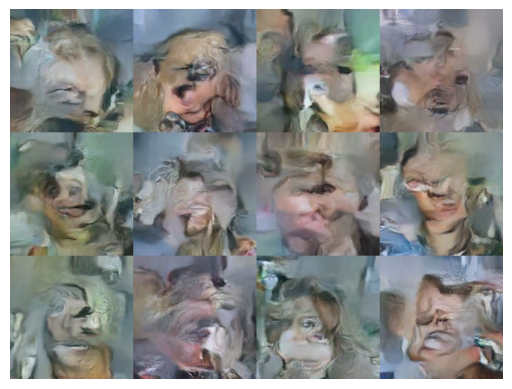

In [15]:
import matplotlib.pyplot as plt

def Test(config, pipeline, model):
    # Perform reverse diffusion process with noisy images.
    noisy_sample = torch.randn(
        config.eval_batch_size,
        config.image_channels,
        config.image_size,
        config.image_size).to(device)

    # Reverse diffusion for T timesteps
    images = pipeline.sampling(model, noisy_sample, device=torch.device("cuda"))

    # Postprocess and save sampled images
    images = postprocess(images)
    image_grid = create_images_grid(images, rows=3, cols=4)

    grid_save_dir = Path(config.output_dir, "samples")
    print('grid_save_dir')
    # grid_save_dir.mkdir(parents=True, exist_ok=True)
    # image_grid.save(f"{grid_save_dir}/test.png")

        # Display the saved image
    plt.imshow(image_grid)
    plt.axis('off')
    plt.show()

device = torch.device("cuda")
config = training_config
# model = UNet(image_size=training_config.image_size,input_channels=training_config.image_channels).to(device)
diffusion_pipeline = DDPMPipeline(beta_start=1e-4, beta_end=1e-2, num_timesteps=training_config.diffusion_timesteps)
# checkpoint = torch.load('~/model/model.pth', map_location='cpu')
checkpoint_path = os.path.expanduser('~/model/model.pth')
model.load_state_dict(checkpoint['model'])
model.eval()  # Set the model to evaluation mode for testing
Test(config,diffusion_pipeline,model)
